<a href="https://www.kaggle.com/code/theongy/getting-started-maneuver-detection?scriptVersionId=120424735" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
"""Command line to load the data (valid only for this notebook)"""
import sys
package_paths = [
    '../input/hackathon2023/',
]

for pth in package_paths:
    sys.path.append(pth)
!cp -r '../input/maneuver-detection/' '/kaggle/working'

cp: cannot stat '../input/maneuver-detection/': No such file or directory


# Loading the dataset

A custom pytorch dataset is provided. It will parse the json dataset can be used with the pytorch loader. Since loading can sometimes take time, it is recommanded to execute the following cell at the beginning separately.

In [4]:
from ManeuverDetectionDataset import ManeuverDetectionDataset
dataset_path="TRAIN_1_IRREGULAR_STEPS_V2.json"
train_dataset= ManeuverDetectionDataset(dataset_path,filter_samples="MANEUVER_ONLY")



**********TRAIN DATASET *********
Validation/Train ratio: 0.1
Samples filtered? MANEUVER_ONLY
Samples evenly spaced? False
path: TRAIN_1_IRREGULAR_STEPS_V2.json
loading dataset. Ready in a minute!
TRAIN Dataset loaded. Size: 17902


In [5]:
from ManeuverDetectionDataset import ManeuverDetectionDataset
train_dataset= ManeuverDetectionDataset(dataset_path,imported_dataset=train_dataset.dataset)



**********TRAIN DATASET *********
Validation/Train ratio: 0.1
Samples filtered? NO
Samples evenly spaced? False
path: TRAIN_1_IRREGULAR_STEPS_V2.json
TRAIN Dataset loaded. Size: 17902


As you can see, by default, the dataset is considered as a train dataset and 10% is not loaded for validation. To build the validation dataset, yo can do the same and you don't need to load again the json to save time ! **Beware : if you modify the code, you should take care to avoid to validate your model with the trained data!**

In [39]:
dataset= ManeuverDetectionDataset(dataset_path,dataset_type="VALIDATION",imported_dataset=train_dataset.dataset,filter_samples="MANEUVER_ONLY")



**********VALIDATION DATASET *********
Validation/Train ratio: 0.1
Samples filtered? MANEUVER_ONLY
Samples evenly spaced? False
path: TRAIN_1_IRREGULAR_STEPS_V2.json
VALIDATION Dataset loaded. Size: 1989


In [40]:
validation_dataset= ManeuverDetectionDataset(dataset_path,dataset_type="VALIDATION",imported_dataset=train_dataset.dataset,filter_samples="MANEUVER_ONLY")



**********VALIDATION DATASET *********
Validation/Train ratio: 0.1
Samples filtered? MANEUVER_ONLY
Samples evenly spaced? False
path: TRAIN_1_IRREGULAR_STEPS_V2.json
VALIDATION Dataset loaded. Size: 1989


In [37]:
import json
import os
import numpy as np
import torch
from torch.utils.data import Dataset

HOUR = 3600
DURATION_KEY = "duration_from_last_measurement"
OBSERVATION_TIME_SPAN = 48 * HOUR
KEY_IDENTIFIER = "keys"
INDEX_KEY = "Case index"
MANEUVER_TIME_KEY = "Maneuver Time (s)"
DELTA_V_KEY = "Delta V (m/s)"
SAMPLE_INFO_KEY = "task"
SK_TYPE_KEY = "Sk type"
MANEUVERS_KEY = "maneuvers"
MAXIMUM_MEASUREMENT_COUNT_BY_SAMPLE = 1000
RESIDUAL_KEY = "residuals"
RIGHT_ASCENSION_KEY = "RA"
DECLINATION_KEY = "DEC"

class ManeuverDetectionDataset(Dataset):
    """Parser for the maneuver detection dataset

        Parameters
        ----------
        dataset_path : str
            The dataset location.
        dataset_type : str, optional (default is TRAIN).
            Either "TRAIN","VALIDATION" or "TEST". Train and Validation are created from the
            dataset file according to the validation_size_ratio. Test dataset does not
            return any maneuver information in the __iter__: function.
        validation_size_ratio:float, optional (default is 0.1)
            The size of the Validation dataset will be validation_size_ratio*total_dataset_length
            The size of the Train dataset will be (1-validation_size_ratio)*total_dataset_length
        max_size:int, optional (default is None)
            If None, the whole dataset will be kept. If specified, the dataset will not exceed this size.
        imported_dataset:dict, optional (default is None)
            If None, the dataset will be imported from the dataset_path. Else, the dictionary given (with the correct
            dataset structure) will be used. It is usefull to avoid to load in RAM twice the dataset for the validation
            and the train dataset.
        filter_samples:str, optional (default is "NO")
            Either "NO","MANEUVER_ONLY","WITHOUT_MANEUVER_ONLY". It helps to filter the relevant samples (for example,
            you may want to use only the maneuvers to train the networks to estimate the date and the dv of the maneuver)
        fixed_step:bool, optional (default is False)
            If False, the features are padded with 0 to fit a fixed size of 1000 measurements by sample.
            If True, the features are not padded (to use with evenly spaced measurements dataset where the number of
            measurements is the same for every sample)
        add_time_feature:bool, optional (default is True)
            If true, the features will have the following shape (measurements_count_by_sample,3).the first two features
            are the residuals (Right Ascension and declination). The second feature is the duration from the start of the
            observation.
            If false, the features will have the following shape (measurements_count_by_sample,2)
        """
    def __init__(self, dataset_path, dataset_type="TRAIN", validation_size_ratio=0.1, max_size=None,
                 imported_dataset=None, filter_samples="NO", fixed_step=False, add_time_feature=True):
        check_arguments(dataset_type, filter_samples)
        print("\n\n**********" + dataset_type + " DATASET *********")
        print(f"Validation/Train ratio: {validation_size_ratio}")
        print(f"Samples filtered? {filter_samples}")
        print(f"Samples evenly spaced? {fixed_step}")
        self.dataset_type = dataset_type
        self.filter_samples = filter_samples
        self.add_time_feature = add_time_feature
        self.dataset_path = dataset_path
        print("path: " + self.dataset_path)
        self.dataset = import_dataset(dataset_path, imported_dataset, filter_samples)
        self.measurements_count_by_sample = MAXIMUM_MEASUREMENT_COUNT_BY_SAMPLE if not fixed_step \
            else fixed_measurement_count_by_sample(self.dataset)
        self.length = compute_length(dataset_type, validation_size_ratio, len(self.dataset[KEY_IDENTIFIER]), max_size)
        print(f"{dataset_type} Dataset loaded. Size: {self.length}")

    def __len__(self):
        return self.length

    def __getitem__(self, torch_loader_index):
        dataset_index = torch_loader_index if (self.dataset_type == "TRAIN" or self.dataset_type == "TEST") else -torch_loader_index-1
        sample_key = self.dataset[KEY_IDENTIFIER][dataset_index]
        sample = self.dataset[sample_key]
        features = parse_sample(sample, self.measurements_count_by_sample, self.add_time_feature)
        if self.dataset_type=="TEST":
            return features,0,0.,0.
        else:
            maneuver_info = get_maneuver_info(sample)
            return features, is_maneuver(sample), maneuver_info[DELTA_V_KEY], maneuver_info[MANEUVER_TIME_KEY]


def compute_length(dataset_type, validation_size_ratio, total_dataset_length, max_size):
    length = total_dataset_length if max_size is None else min(max_size, total_dataset_length)
    if dataset_type == "TRAIN":
        return round(length * (1 - validation_size_ratio))
    elif dataset_type == "VALIDATION":
        return round(length * validation_size_ratio)
    elif dataset_type == "TEST":
        return length


def load(dataset_path):
    print("loading dataset. Ready in a minute!")
    with open(dataset_path, "r") as dataset_file:
        return json.load(dataset_file)


def is_maneuver(sample):
    return 0 if OBSERVATION_TIME_SPAN < get_maneuver_info(sample)[MANEUVER_TIME_KEY] else 1


def get_maneuver_info(sample):
    return {DELTA_V_KEY: 0., MANEUVER_TIME_KEY: 2 * OBSERVATION_TIME_SPAN} if len(
        sample[SAMPLE_INFO_KEY][MANEUVERS_KEY]) == 0 else sample[SAMPLE_INFO_KEY][MANEUVERS_KEY][0]


def get_observation_time_span(file_name):
    dates_string = file_name.split(os.path.sep)[1].split(" ")[5]
    observation_start = dates_string.split("to")[0]
    observation_end = dates_string.split("to")[1]
    return observation_end, observation_start


def get_residuals(sample, key):
    return sample[RESIDUAL_KEY][key]


def get_duration(sample):
    return sample[RESIDUAL_KEY][DURATION_KEY]


def check_arguments(dataset_type, filter_samples):
    dataset_type_keys = {"TRAIN", "TEST", "VALIDATION"}
    assert dataset_type in dataset_type_keys, f"Invalid 'dataset type' argument {dataset_type}. " \
                                              f"dataset_type should be in {dataset_type_keys}"
    filter_samples_keys = {"NO", "MANEUVER_ONLY", "WITHOUT_MANEUVER_ONLY"}
    assert filter_samples in filter_samples_keys, f"Invalid 'filter sample' argument {filter_samples}. " \
                                                  f"'filter sample' should be in {filter_samples_keys}"
    if dataset_type=="TEST":
        assert  filter_samples=="NO","Impossible to filter maneuvers, since you don't know them in the TEST dataset... " \
                                     "nice try :P "

def fixed_measurement_count_by_sample(dataset):
    return len(get_residuals(dataset[dataset[KEY_IDENTIFIER][0]], RIGHT_ASCENSION_KEY))

def parse_sample(sample, measurements_count_by_sample, time_feature):
    feature_count = 3 if time_feature else 2
    features = np.zeros((measurements_count_by_sample, feature_count))
  
    for i, key in enumerate([RIGHT_ASCENSION_KEY, DECLINATION_KEY]):
        residuals = get_residuals(sample, key)
        features[:len(residuals), i] = residuals
    if time_feature:
        duration = get_duration(sample)
        features[:len(duration), 2] = duration
     
    valid_index=[]
    features=torch.from_numpy(features)
    for idx in range(features.shape[0]):
        if not torch.all(features[idx,:]==0):
            valid_index.append(idx)
    features=features[valid_index,:]
    features=features.reshape(1,features.shape[0],features.shape[1])
    features_transpose=features.transpose(1,2)
    features_interpolate=torch.nn.functional.interpolate(features_transpose,size=1000,mode="linear",align_corners=False)
    features_interpolate=torch.nn.functional.interpolate(features_transpose,size=5000,mode="linear",align_corners=False)
    features_interpolate=features_interpolate.transpose(1,2)
    features_interpolate=features_interpolate[0]
    features_interpolate[:,2]=features_interpolate[:,2]/(48*3600)
    
    return features_interpolate
def import_dataset(dataset_path, imported_dataset, filter_samples):
    dataset = imported_dataset if imported_dataset is not None else load(dataset_path)
    if filter_samples is "NO":
        return dataset
    elif filter_samples is "MANEUVER_ONLY":
        maneuver_keys_index = [True if is_maneuver(dataset[key]) else False for key in dataset[KEY_IDENTIFIER]]
        dataset[KEY_IDENTIFIER] = list(np.array(dataset[KEY_IDENTIFIER])[maneuver_keys_index])
    elif filter_samples is "WITHOUT_MANEUVER_ONLY":
        without_maneuver_keys_index = [True if not is_maneuver(dataset[key]) else False for key in
                                       dataset[KEY_IDENTIFIER]]
        dataset[KEY_IDENTIFIER] = list(np.array(dataset[KEY_IDENTIFIER])[without_maneuver_keys_index])
    return dataset


<>:170: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:172: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:175: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:170: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:172: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:175: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\drag-\AppData\Local\Temp\ipykernel_19856\3137077108.py:170: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if filter_samples is "NO":
C:\Users\drag-\AppData\Local\Temp\ipykernel_19856\3137077108.py:172: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif filter_samples is "MANEUVER_ONLY":
C:\Users\drag-\AppData\Local\Temp\ipykernel_19856\3137077108.py:175: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif filter_samples is "WITHOUT_MANEUVER_ONLY":


In [9]:
train_dataset= ManeuverDetectionDataset(dataset_path,imported_dataset=train_dataset.dataset,filter_samples="MANEUVER_ONLY")



**********TRAIN DATASET *********
Validation/Train ratio: 0.1
Samples filtered? MANEUVER_ONLY
Samples evenly spaced? False
path: TRAIN_1_IRREGULAR_STEPS_V2.json
TRAIN Dataset loaded. Size: 17902


Finally, you can create your pytorch loader and have fun with your networks !

In [10]:
from torch.utils.data import DataLoader


# 1550 batch = nb de sats observés
loader = DataLoader(train_dataset, batch_size=17902, drop_last=True)
feature,is_maneuver,maneuver_dv,maneuver_time =next(iter(loader))
#print(f"features shape (batch size * nb of meas * nb of feature):{feature.shape}\nis maneuver: {is_maneuver.item()}\ndv (m/s): {maneuver_dv.item()}\nmaneuver date (seconds from the observation start): {maneuver_time.item()}")

In [11]:
import pickle
with open("maneuver_time.pickle",'wb') as f:
    pickle.dump(maneuver_time,f)

In [8]:
feature.shape

torch.Size([17902, 5000, 3])

In [12]:
feature.shape

torch.Size([500, 1000, 3])

In [1]:
import matplotlib.pyplot as plt

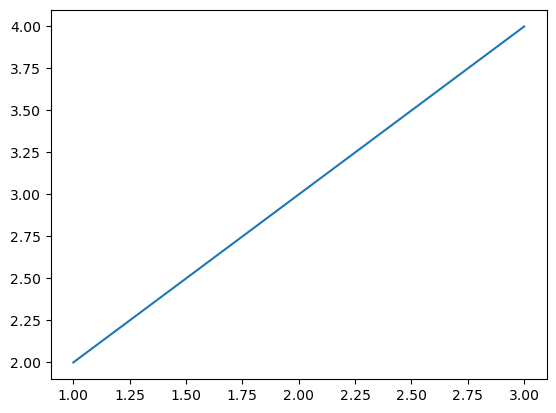

In [2]:
plt.plot([1,2,3],[2,3,4])

In [ ]:
plt.scatter(feature[0][:,2].numpy(),feature[0][:,1].numpy())

In [435]:
'''
for batch in range(17902):
    if batch%1000==0:
        print(batch)
    data=feature[batch]
    valid_index=[]
    for idx in range(data.size(0)):
        if not torch.all(data[idx,:]==0):
            valid_index.append(idx)
    data=data[valid_index,:]
    data=data.reshape(1,data.shape[0],data.shape[1])
    data_transpose=data.transpose(1,2)
    data_interpolate=torch.nn.functional.interpolate(data_transpose[:,:,1:],size=1000,mode="linear",align_corners=False)
    data_interpolate=data_interpolate.transpose(1,2)
    feature[batch]=data_interpolate[0]
'''

0


In [16]:
feature_transpose=feature.transpose(1,2)
feature_interpolate=torch.nn.functional.interpolate(feature_transpose,size=5000,mode="linear",align_corners=False)
feature_interpolate=feature_interpolate.transpose(1,2)

In [17]:
feature_interpolate.shape

torch.Size([500, 5000, 3])

In [12]:
import matplotlib.pyplot as plt

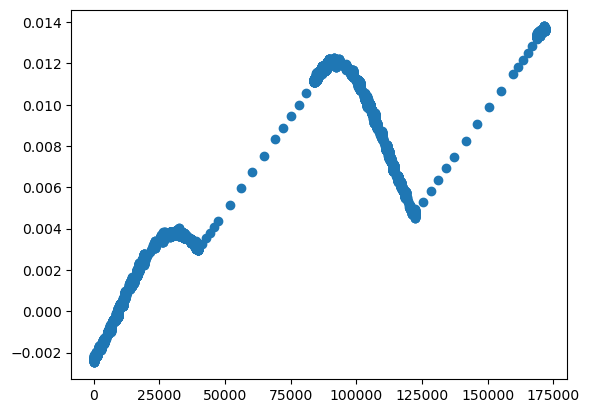

In [19]:
plt.scatter(feature_interpolate[0][:,2].numpy(),feature_interpolate[0][:,1].numpy())

In [20]:

maneuver_min=maneuver_time.min()
maneuver_max=maneuver_time.max()
maneuver_time=(maneuver_time-maneuver_min)/(maneuver_max-maneuver_min)

In [398]:
feature_interpolate[0]

tensor([[4.8176e-01, 4.4237e-01, 6.7522e-05],
        [4.8176e-01, 4.4237e-01, 6.7522e-05],
        [4.8176e-01, 4.4237e-01, 6.7522e-05],
        ...,
        [1.3894e-01, 6.4875e-01, 9.9389e-01],
        [1.3894e-01, 6.4875e-01, 9.9389e-01],
        [1.3894e-01, 6.4875e-01, 9.9389e-01]], dtype=torch.float64)

In [21]:
feature_interpolate_norm[:,:,1]

tensor([[0.4344, 0.4344, 0.4344,  ..., 0.7336, 0.7336, 0.7336],
        [0.4965, 0.4965, 0.4965,  ..., 0.2649, 0.2649, 0.2649],
        [0.5797, 0.5797, 0.5797,  ..., 0.5806, 0.5806, 0.5806],
        ...,
        [0.3499, 0.3499, 0.3499,  ..., 0.2596, 0.2596, 0.2596],
        [0.3789, 0.3789, 0.3789,  ..., 0.4774, 0.4774, 0.4774],
        [0.2816, 0.2816, 0.2816,  ..., 0.6375, 0.6375, 0.6375]],
       dtype=torch.float64)

In [400]:
feature.shape, is_maneuver.shape, maneuver_dv.shape, maneuver_time.shape

(torch.Size([17902, 1000, 3]),
 torch.Size([17902]),
 torch.Size([17902]),
 torch.Size([17902]))

In [307]:
input_feature = feature_interpolate_norm.numpy()
input_is_man = is_maneuver.numpy()
input_dv = maneuver_dv.numpy()
input_time = maneuver_time.numpy()

In [115]:
input_feature[9][:]
input_is_man

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [1]:
import matplotlib.pyplot as plt

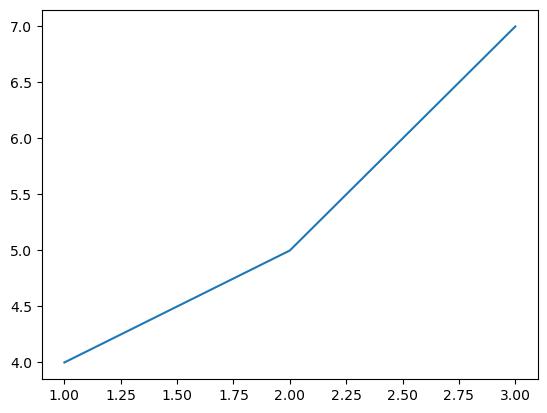

In [2]:
plt.plot([1,2,3],[4,5,7])

In [ ]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(nrows=10, ncols=2, figsize=(12,40))
for i in range(10):
    ax[i][0].scatter(input_feature[i][:,2], input_feature[i][:,0])
    ax[i][0].set_title("Maneuver "+str(input_is_man[i]))
    ax[i][1].scatter(input_feature[i][:,2], input_feature[i][:,1])
    ax[i][1].set_title("Maneuver "+str(input_is_man[i]))

In [1]:
plt.scatter(input_feature[6][:,2], input_feature[6][:,1])

NameError: name 'plt' is not defined

## Try with simple NN 

In [17]:
import torch
import torch.nn as nn

In [326]:
n_input, n_hidden, n_out, batch_size, learning_rate = 2000, 500, 1, 35762, 0.005

In [327]:
data_x = feature_interpolate
data_y = is_maneuver.double()

In [328]:
print(data_x.size())
print(data_y.size())

torch.Size([17902, 8000, 3])
torch.Size([17902])


In [16]:
model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      nn.Sigmoid())
model.double()
print(model)

Sequential(
  (0): Linear(in_features=2000, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=1, bias=True)
  (3): Sigmoid()
)


In [17]:
#loss_function = nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
losses = []
for epoch in range(300):
    print("Epoch "+str(epoch))
    pred_y = model(data_x.reshape(-1, 2000))
    loss = loss_function(pred_y.reshape(batch_size), data_y)
    losses.append(loss.item())

    model.zero_grad()
    loss.backward()

    optimizer.step()

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110


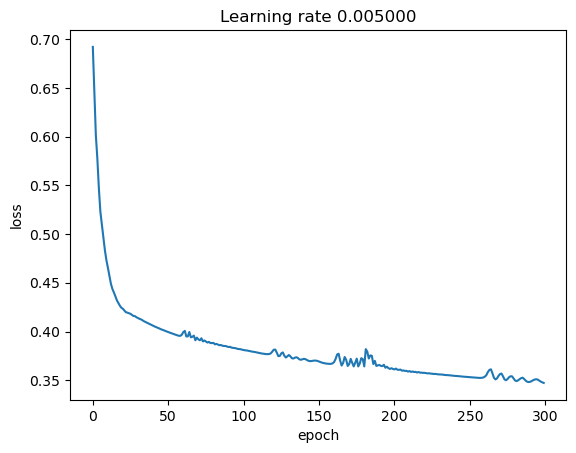

In [19]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

In [505]:
#Save the mpdel
PATH = './model_manoeuvre.pth'
torch.save(model.state_dict(), PATH)

In [41]:
valid_batch_size = 1989
loader2 = DataLoader(validation_dataset, batch_size=valid_batch_size, drop_last=True)
feature2,is_maneuver2,maneuver_dv2,maneuver_time2 =next(iter(loader2))

In [112]:
feature2.shape

torch.Size([1989, 5000, 3])

In [42]:
pred2 = model_time(feature2.reshape(-1, 15000))

In [114]:
pred2.shape

torch.Size([1989, 1])

In [45]:
y_valid=(maneuver_time2-maneuver_time.min())/(maneuver_time.max()-maneuver_time.min())
loss = loss_function(pred2.reshape(valid_batch_size),y_valid)
loss

tensor(0.1619, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [24]:
TT, FT, TF, FF = 0, 0, 0, 0
NC = 0

pred_maneuver = []

for i in range(len(pred2)):
    #print(pred2[i].detach().numpy()[0] - is_maneuver2.numpy()[i])
    val = pred2[i].detach().numpy()[0] - is_maneuver2.numpy()[i]
    if (abs(val) < 0.5) & (is_maneuver2.numpy()[i] == 1):
        TT += 1
        pred_maneuver.append(1)
    elif (abs(val) < 0.5) & (is_maneuver2.numpy()[i] == 0):
        TF += 1
        pred_maneuver.append(0)
    elif (abs(val) > 0.5) & (is_maneuver2.numpy()[i] == 0):
        FT += 1
        pred_maneuver.append(1)
    elif (abs(val) > 0.5) & (is_maneuver2.numpy()[i] == 1):
        FF += 1
        pred_maneuver.append(0)
    else:
        NC += 1
        print(pred2[i].detach().numpy()[0])
print("")
print('TP', 'TN', 'FP', 'FN')
print(TT, TF, FT, FF)
print(NC)
print('Accuracy', (TT+TF)/valid_batch_size *100, '%')


TP TN FP FN
1345 1958 37 634
0
Accuracy 83.11524911927529 %


In [25]:
from sklearn.metrics import classification_report
import numpy as np

pred_maneuver = np.array(pred_maneuver)
real_maneuver = is_maneuver2.numpy()

print(classification_report(real_maneuver, pred_maneuver))

              precision    recall  f1-score   support

           0       0.76      0.98      0.85      1995
           1       0.97      0.68      0.80      1979

    accuracy                           0.83      3974
   macro avg       0.86      0.83      0.83      3974
weighted avg       0.86      0.83      0.83      3974



### Time prediction

In [12]:
n_input, n_hidden, n_out, batch_size, learning_rate = 15000, 1000,1,17902 , 0.005

In [13]:
data_x = feature
data_y = (maneuver_time-maneuver_time.min())/(maneuver_time.max()-maneuver_time.min()).double()

In [14]:
data_y

tensor([0.2453, 0.8612, 0.9463,  ..., 0.9780, 0.6315, 0.4409],
       dtype=torch.float64)

In [62]:
model_time = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      nn.Tanh())
model_time.double()
print(model_time)

Sequential(
  (0): Linear(in_features=15000, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=1, bias=True)
  (3): Tanh()
)


In [63]:
model_time.load_state_dict(torch.load("model_time.pth"))
model_time.eval()

Sequential(
  (0): Linear(in_features=15000, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=1, bias=True)
  (3): Tanh()
)

In [64]:
loss_function = nn.L1Loss()
optimizer = torch.optim.SGD(model_time.parameters(), lr=learning_rate)

In [ ]:
losses = []
for epoch in range(10):
    print("Epoch "+str(epoch))
    pred_y = model_time(data_x.reshape(-1,15000))
    loss = loss_function(pred_y.reshape(batch_size), data_y)
    losses.append(loss.item())

    model_time.zero_grad()
    loss.backward()

    optimizer.step()

Epoch 0
Epoch 1


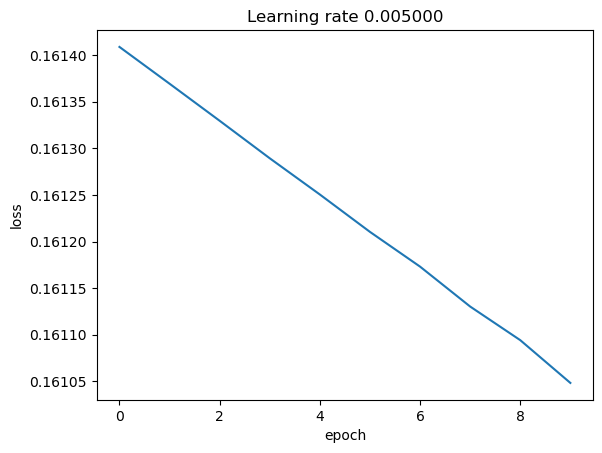

In [68]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

In [107]:
import pickle
with open("feature.pickle",'wb') as f:
    pickle.dump(feature,f)

In [171]:
#Save the mpdel
PATH = './model_time.pth'
torch.save(model_time.state_dict(), PATH)

## Florian test

In [258]:
# Paramètres du modèle

# number of features (len of X cols)
input_dim = 10000
# number of nodes first hidden layer
hidden_nodes_layer_1 = 500
# number of nodes second hidden layer
hidden_nodes_layer_2 = 100

# number of classes (unique of y)
output_dim = 1
# learning rate
lr = 0.001

# Construction du modèle

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_nodes_layer_1)
        self.fc2 = nn.Linear(hidden_nodes_layer_1, hidden_nodes_layer_2)
        self.fc3 = nn.Linear(hidden_nodes_layer_2, output_dim)  
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
  
# Initialisiation du modèle
model = Network()
model.double()
criterion = nn.BCELoss()


In [357]:
lr=0.00008
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [260]:
data_x = feature[:,:,:2]
data_y = is_maneuver.double()

In [259]:
data_x.shape

torch.Size([35762, 5000, 2])

In [207]:
import torch.nn .functional as F

In [358]:
losses = []
for epoch in range(50):
    print("Epoch "+str(epoch))
    pred_y = model(data_x.reshape(-1, 10000))
    loss = criterion(pred_y.reshape(35762), data_y)
    losses.append(loss.item())

    model.zero_grad()
    loss.backward()

    optimizer.step()

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49


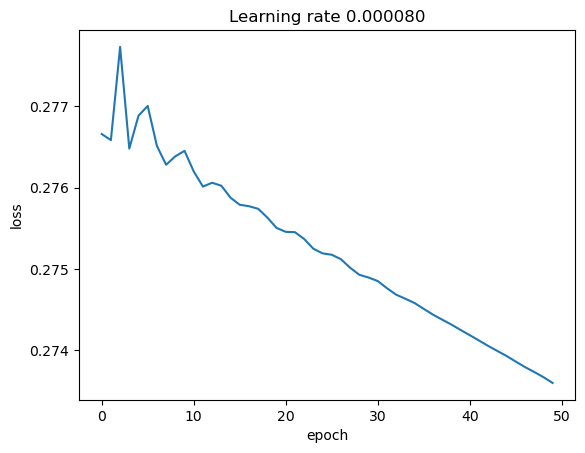

In [359]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(lr))
plt.show()

In [20]:
loader2 = DataLoader(validation_dataset, batch_size=1789, drop_last=True)
feature2,is_maneuver2,maneuver_dv2,maneuver_time2 =next(iter(loader2))

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[ 9.7650000e-02 -8.4490000e-04  5.9021896e+04]
 [ 9.7700000e-02 -1.0210000e-03  5.9033259e+04]
 [ 9.7630000e-02 -9.4340000e-04  5.9044645e+04]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]]


TypeError: all(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [360]:
pred = model(feature2[:,:,:2].reshape(-1, 10000))

In [326]:
pred.shape

torch.Size([3974, 1])

In [361]:
#fonction pour passer les scores en prédictions
def tri(outputs):
    outputs_np = outputs.detach().numpy()
    
    for i in range(len(outputs_np)):
        if outputs_np[i] > 0.5:
            outputs_np[i]=1
        elif outputs_np[i]<=0.5:
            outputs_np[i]=0

    return outputs_np.reshape(-1)

In [362]:
from sklearn.metrics import classification_report

pred=tri(pred)
print(classification_report(is_maneuver2, pred))


              precision    recall  f1-score   support

           0       0.83      1.00      0.90      1995
           1       0.99      0.79      0.88      1979

    accuracy                           0.89      3974
   macro avg       0.91      0.89      0.89      3974
weighted avg       0.91      0.89      0.89      3974



--------------------------------------------------------------------------------

To load the test dataset, you should set the dataset type to TEST:

In [46]:
test_dataset_path="TEST_FILE_PUBLIC.json"
test_dataset= ManeuverDetectionDataset(test_dataset_path,dataset_type="TEST")
test_loader = DataLoader(test_dataset, batch_size=1559, drop_last=True)
feature_test, is_maneuver_test ,maneuver_dv_test, maneuver_time_test =next(iter(test_loader))
#print(f"features shape (batch size * nb of meas * nb of feature):{feature.shape}\nis maneuver: {is_maneuver.item()}\ndv (m/s): {maneuver_dv.item()}\nmaneuver date (seconds from the observation start): {maneuver_time.item()}")




**********TEST DATASET *********
Validation/Train ratio: 0.1
Samples filtered? NO
Samples evenly spaced? False
path: TEST_FILE_PUBLIC.json
loading dataset. Ready in a minute!
TEST Dataset loaded. Size: 1559


In [47]:
feature_test.shape

torch.Size([1559, 5000, 3])

In [48]:
len(test_dataset)

1559

In [515]:
feature_test.shape

torch.Size([1559, 1000, 3])

In [49]:
pred_test = model_time(feature_test.reshape(-1, 15000))

In [50]:
pred_test.shape

torch.Size([1559, 1])

In [520]:
loss_function = nn.BCELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [51]:
pred_test_renorm=pred_test*(maneuver_time.max()-maneuver_time.min())+maneuver_time.min()

In [53]:
pred_test_renorm.max()

tensor(156787.9719, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [376]:
pred_test_renorm.max()

tensor(313576.0638, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [55]:
import pandas as pd

In [56]:
sub=pd.read_csv("prediction.csv",delimiter=";")

In [57]:
sub["detection"]

0       1
1       1
2       0
3       0
4       0
       ..
1554    0
1555    0
1556    0
1557    0
1558    0
Name: detection, Length: 1559, dtype: int64

for evenly spaced dataset, you should use the option fixed_step : 


In [ ]:
evenly_spaced_dataset_path="TRAIN_1_EVENLY_SPACED_V2.json/TRAIN_1_EVENLY_SPACED_V2.json"
evenly_spaced_dataset= ManeuverDetectionDataset(evenly_spaced_dataset_path,fixed_step=True)
evenly_spaced_loader = DataLoader(evenly_spaced_dataset, batch_size=1, drop_last=True)
feature,is_maneuver,maneuver_dv,maneuver_time =next(iter(evenly_spaced_loader))
print(f"features shape (batch size * nb of meas * nb of feature):{feature.shape}\nis maneuver: {is_maneuver.item()}\ndv (m/s): {maneuver_dv.item()}\nmaneuver date (seconds from the observation start): {maneuver_time.item()}")




**********TRAIN DATASET *********
Validation/Train ratio: 0.1
Samples filtered? NO
Samples evenly spaced? True
path: TRAIN_1_EVENLY_SPACED_V2.json/TRAIN_1_EVENLY_SPACED_V2.json
loading dataset. Ready in a minute!


#  It is time to submit !

When you think that your score is great you can submit ! To get started, you can generate your prediction file :

In [8]:
from SubmissionGenerator import create_submission
import numpy as np
#fake prediction
pred=np.zeros((len(test_dataset),3))
pred[:,0]=sub["detection"] # classification
pred[:,1]=0.01*np.ones((len(test_dataset))) #dv
pred[:,2]=pred_test_renorm #time of the maneuver
create_submission(pred,"/kaggle/working/prediction")


In [526]:
model_maneuver

list

In [60]:
from SubmissionGenerator import create_submission
import numpy as np
#fake prediction
pred=np.zeros((len(test_dataset),3))
pred[:,0]=sub["detection"] # classification
pred[:,1]=0.01*np.ones((len(test_dataset))) #dv
pred[:,2]=pred_test_renorm.detach().numpy().reshape(-1) #time of the maneuver
create_submission(pred,"./prediction4.csv")

array([63156.75392668, 49568.68907975, 91123.14804298, ...,
       56709.49589308, 69294.57413386, 53983.53991283])

Then, commit the file prediction.csv in the gitlab repository of your team. Don't forget to pull the repo before!
https://gitlab.com/TheoNguyen611/team-1-la-photomentalteam.git

https://gitlab.com/TheoNguyen611/team-2-avada-kedavra.git

https://gitlab.com/TheoNguyen611/team-3-frosty-gould.git

Wait a few moment and you should see your score appear in the leaderboard : http://34.163.85.74:5006/dashboard